In [1]:
README = '''
Julian Smoller ~ 2018

The purpose of this project is to play around with the old computer game "Sim Tower." 
In this notebook, I attempt to replicate a Sim Tower as an image. 

Notes:
Optimal Tower design:
Width: 18 Condos = 32 Offices (exactly!)

Stairs:
Two sets of stairs, evenly spaced, no more than 8 offices away:
8 offices | stairs | 8 offices | 8 offices | stairs | 8 offices
=> 32 offices per floor
OOOOOOOO S OOOOOOOO OOOOOOOO S OOOOOOOO
=> one between 8th and 9th offices, one between 24th and 25th offices

Standard Elevators:
Three elevators, evenly spaced with 3 condos on either side:
CCC E CCC CCC E CCC CCC E CCC 
=> Between condos: (3,4), (9,10), (15,16)
3 elevators spanning floors (0,13), (15,28), (30,43), (45,58) => 12
2 elevators spanning floors (60,73) => 2
1 elevator spanning floors (73,100) => 1
==> 15 total

Express Elevators:
Horizontal location does not matter, so you can group them on the left or right
2 per lobby for floors 15, 30, 45, 60 => 8
1 for lobby for floor 75 => 1
==> 9 total
===> 24 elevators total


Floorplan:

30 Lobby
28-29 Food/Shops
24-27 Condos
19-23 Hotel
16-18 Offices
-------------
15 Lobby
13-14 Food/Shops
8-12 Hotel
5-7 Condos
4 Offices
1-3 Lobby
-------------

Income:
Ground floor lobby does not cost anything for maintenance
Each housekeeping unit costs 100(x100) per quarter for maintenance

'''

In [7]:
import os
import pandas as pd
#import moviepy.editor as mpy
import math
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import colorsys
import random
#import webcolors
import pickle
from Julian import *

%matplotlib inline

# Prepare data: sky

In [18]:
# Create + save color combos to pickle file
def mix_colors(colors,n=3):
    colors_new = []
    for i in range(n): # for each of the colors to be generated
        x = (i/(n-1))*(len(colors)-1) # map to list of colors given
        if x%1==0: # if exactly equal to a given color, e.g. last color
            color_new = colors[int(x)]
        else:  # need to mix two colors
            x0 = int(x)
            x1 = int(x+1)
            p1 = x%1 # percent of color 0
            p0 = 1-p1 # percent of color 1
            color0 = colors[x0]
            color1 = colors[x1]
            color_new = tuple([int(c0*p0+c1*p1) for c0,c1 in zip(color0,color1)])
        colors_new.append(color_new)
    return colors_new
#mix_colors([(0,0,0),(255,255,255)],n=3)

def create_sky_colors():
    n_color_combos = 100
    n_colors_per_combo = 8 # 1 per sky zone
    cc = [] # color combos recorded from game
    cc.append([(0,2,51),(1,3,64),(5,11,64),(0,2,47),
               (1,7,95),(29,50,111),(1,7,95),(0,2,47)]) # Night
    cc.append([(44,22,68),(44,26,68),(60,30,80),(52,25,59),
               (56,31,103),(81,66,100),(56,31,103),(52,25,59)]) # Sky 1
    cc.append([(68,34,76),(68,37,68),(84,38,88),(80,41,69),
               (84,47,111),(108,74,97),(84,47,111),(80,41,69)]) # Sky 2
    cc.append([(96,45,84),(96,53,69),(120,54,96),(116,57,77),
               (120,67,116),(145,82,94),(120,67,116),(116,57,77)]) # Sky 3
    cc.append([(120,57,93),(120,69,74),(145,62,105),(145,70,86),
               (149,79,120),(172,90,91),(149,79,120),(145,70,86)]) # Sky 4
    cc.append([(157,74,105),(157,85,75),(184,79,117),(184,90,98),
               (193,102,130),(213,102,85),(193,102,130),(184,90,98)]) # Sky 5
    cc.append([(184,90,114),(188,101,77),(221,91,131),(221,106,111),
               (225,122,135),(249,114,83),(225,122,135),(221,106,111)]) # Sky 6
    cc.append([(177,102,134),(177,117,99),(209,107,146),(217,122,126),
               (225,139,151),(249,130,102),(225,139,151),(217,122,126)]) # Sky 7
    cc.append([(153,122,161),(154,138,134),(185,131,169),(198,143,158),
               (214,159,174),(237,154,136),(214,159,174),(198,143,158)]) # Sky 8
    cc.append([(130,139,188),(126,154,169),(158,155,198),(182,166,185),
               (199,182,199),(230,182,171),(199,182,199),(182,166,185)]) # Sky 9
    cc.append([(111,155,213),(104,170,201),(139,175,217),(167,183,214),
               (186,199,218),(223,203,203),(186,199,218),(167,183,214)]) # Sky 10
    cc.append([(89,171,236),(86,187,233),(116,196,241),(152,204,237),
               (175,219,242),(211,227,235),(175,219,242),(152,204,237)]) # Sky 11
    cc.append([(82,179,248),(77,196,249),(106,204,249),(145,212,249),
               (168,227,259),(208,235,259),(168,227,259),(145,212,249)]) # Day
    cc_mixed = [[] for i in range(n_color_combos)]
    for i in range(n_colors_per_combo):
        colors = [combo[i] for combo in cc]
        colors_mixed = mix_colors(colors,n=n_color_combos)
        for j,color in enumerate(colors_mixed):
            cc_mixed[j].append(color)
    return cc_mixed
# cc = create_sky_colors()
# print(len(cc),'sky color combos created')
# pickle.dump(cc,open('data/sky/color_combos.p','wb'))

def get_blend_matrix(w,h):
    '''Generate a matrix of 0s and 1s, with increasing probability of 1 as rows increase'''
    blend_matrix = np.zeros((h,w),dtype=int)
    for x in range(w):
        for y in range(h):
            blend_matrix[y][x] = int(random.random()<(y/h))
    return blend_matrix
def fill_matrix(template,d):
    '''Populate matrix with values from dictionary (d) based on codes/keys in template'''
    matrix = []
    for row in template:
        new_row = []
        for cell in row:
            new_cell = d[cell]
            new_row.append(new_cell)
        matrix.append(new_row)
    return matrix

# Create and save sky template
def create_sky_template():
    '''Create a 2D array with color codes representing each sky zone'''
    w = 100
    h_sky_zone = 130
    h_blend_zone = 70
    n_sky_zones = 8 # should match number of colors in each color combo
    template = []
    blend_matrix = get_blend_matrix(w,h_blend_zone)
    for i in range(n_sky_zones):
        template.append(np.full((h_sky_zone,w),i))
        if i < n_sky_zones-1: # if sky zone is not the last sky zone, create blend zone
            template.append(fill_matrix(blend_matrix,{0:i,1:i+1}))
    template = np.concatenate(template)
    return template

# template = create_sky_template()
# pickle.dump(template,open('data/sky/template.p','wb'))
# print('created sky template of shape',template.shape)

# Sky

In [22]:
class Sky:
    t_dawn, t_day, t_dusk, t_night = 5,8,17,20
    schedule = [('night',t_dawn),('dawn',t_day),('day',t_dusk),('dusk',t_night),('night',24)]
    color_combos = pickle.load(open('data/sky/color_combos.p','rb'))
    template = pickle.load(open('data/sky/template.p','rb'))
    n_states = len(color_combos)
    def __init__(self,x=0,y=0,w=300,h=300):
        self.x, self.y, self.w, self.h = (x,y,w,h)
        self.t = None
        self.state = None
        self.changed = True 
        self.im = None
    def update(self,t):
        self.t = t
        self.update_state()
        self.update_color_combo()
    def update_state(self):
        state = next(x[0] for x in self.schedule if x[1]>=self.t) 
        if state == 'dawn':
            n = int(((self.t-self.t_dawn)/(self.t_day-self.t_dawn))*self.n_states)
            state += '_' + str(n)
        elif state == 'dusk':
            n = int(((self.t-self.t_dusk)/(self.t_night-self.t_dusk))*self.n_states)
            state += '_' + str(n)
        self.changed = (state != self.state) # keep track of state change from prior update
        self.state = state
    def update_color_combo(self):
        if self.state == 'night':
            color_combo = self.color_combos[0]
        elif self.state.startswith('dawn'):
            n = int(self.state.split('_')[1])
            color_combo = self.color_combos[n]
        elif self.state.startswith('dusk'):
            n = int(self.state.split('_')[1])
            color_combo = self.color_combos[-1*n] # inverted order
        else: # self.state = 'day':
            color_combo = self.color_combos[-1]
        self.color_combo = color_combo
    def render(self):
        # If first time rendering, or if state changed, then create a new image
        if self.im == None or self.changed==True:
            im = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
            for x in range(im.size[0]):
                c = x%self.template.shape[1] # template is probably too narrow, so wrap it
                for y in range(im.size[1]):
                    r = min(y,template.shape[0]-1) # if template is too short, just use the max value
                    color = self.color_combo[self.template[r,c]]
                    im.putpixel((x,y),color)
            self.im = im
        return self.im
    
# sky = Sky()
# sky.update(12)
# sky.render()

# Ground

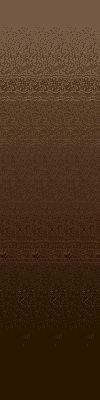

In [25]:
class Ground:
    def __init__(self,x=0,y=0,w=100,h=400):
        self.x, self.y, self.w, self.h = (x,y,w,h)
        self.path = 'data/ground/template.png'
        self.im = self.make_im()
    def make_im(self):
        template = Image.open(self.path)
        im = Image.new('RGBA',(self.w,self.h),(0,0,0,255))
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                x_template = x%template.size[0]
                y_template = min(y,template.size[1]-1)
                color = template.getpixel((x_template,y_template))
                im.putpixel((x,y),color)
        return im
    def render(self):
        return self.im
ground = Ground()
ground.render()

# World

In [19]:
class World:
    h_ground = 396 # based on screenshot from game
    def __init__(self,w=1000,h=1000):
        self.w = w
        self.h = h
        self.ground = Ground(x=0, y=0, w=self.w, h=self.h_ground)
        self.sky = Sky(x=0, y=self.h_ground, w=self.w, h=self.h-self.h_ground)
        self.skyline = Skyline(x=0, y=self.sky.y, w=self.sky.w)
        self.tower = None
        self.im = None
    def make_tower(self):
        self.tower = Tower() 
        self.tower.x = int((self.w-self.tower.w_outer)/2)
        self.tower.y = self.sky.y - self.tower.h_underground
    def update(self,t):
        self.t = t
        self.sky.update(t)
        if self.tower is not None:
            self.tower.update(t)
    def render(self):
        if self.im == None or self.sky.changed:
        # When rendering for the first time, create background
        if self.background = None:
            self.background = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
            # Add ground, sky, and skyline
            for thing in [self.ground, self.sky, self.skyline]:
                im = thing.render()
                xyxy = (thing.x, self.h-(thing.y+im.size[1]), thing.x+im.size[0], self.h-thing.y)
                image.paste(im,xyxy,im)
        # Otherwise, just update sky if necessary
        else:
            
        # Add tower
        im = self.tower.render()
        xyxy = (self.tower.x, self.h-(self.tower.y+im.size[1]), self.tower.x+im.size[0], self.h-self.tower.y)
        image.paste(im,xyxy,im)
        return image

class Ground:
    def __init__(self,x=0,y=0,w=100,h=400):
        self.x, self.y, self.w, self.h = (x,y,w,h)
        self.default_color = (153, 139, 125)
        self.path = 'data/ground/ground_template.png'
        self.im = self.make_im()
    def make_im(self):
        template_im = Image.open(self.path)
        im = Image.new('RGBA',(self.w,self.h),(0,0,0,255))
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                x_template = x%template_im.size[0]
                y_template = min(y,template_im.size[1]-1)
                color = template_im.getpixel((x_template,y_template))
                im.putpixel((x,y),color)
        return im
    def render(self):
        return self.im
    
class Sky:
    t_dawn, t_day, t_dusk, t_night = 5,8,17,20
    schedule = [('night',t_dawn),('dawn',t_day),('day',t_dusk),('dusk',t_night),('night',24)]
    color_combos = pickle.load(open('data/sky/color_combos.p','rb'))
    template = pickle.load(open('data/sky/template.p','rb'))
    n_states = len(color_combos)
    def __init__(self,x=0,y=0,w=300,h=300):
        self.x, self.y, self.w, self.h = (x,y,w,h)
        self.t = None
        self.state = None
        self.changed = True 
        self.im = None
    def update(self,t):
        self.t = t
        self.update_state()
        self.update_color_combo()
    def update_state(self):
        state = next(x[0] for x in self.schedule if x[1]>=self.t) 
        if state == 'dawn':
            n = int(((self.t-self.t_dawn)/(self.t_day-self.t_dawn))*self.n_states)
            state += '_' + str(n)
        elif state == 'dusk':
            n = int(((self.t-self.t_dusk)/(self.t_night-self.t_dusk))*self.n_states)
            state += '_' + str(n)
        self.changed = (state != self.state) # keep track of state change from prior update
        self.state = state
    def update_color_combo(self):
        if self.state == 'night':
            color_combo = self.color_combos[0]
        elif self.state.startswith('dawn'):
            n = int(self.state.split('_')[1])
            color_combo = self.color_combos[n]
        elif self.state.startswith('dusk'):
            n = int(self.state.split('_')[1])
            color_combo = self.color_combos[-1*n] # inverted order
        else: # self.state = 'day':
            color_combo = self.color_combos[-1]
        self.color_combo = color_combo
    def render(self):
        # If first time rendering, or if state changed, then create a new image
        if self.im == None or self.changed==True:
            im = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
            for x in range(im.size[0]):
                c = x%self.template.shape[1] # template is probably too narrow, so wrap it
                for y in range(im.size[1]):
                    r = min(y,template.shape[0]-1) # if template is too short, just use the max value
                    color = self.color_combo[self.template[r,c]]
                    im.putpixel((x,y),color)
            self.im = im
        return self.im
    
class Skyline:
    def __init__(self,x=0,y=0,w=100):
        self.x, self.y, self.w = (x,y,w)
        self.path = 'data/skyline/skyline.txt'
        self.colors = {'a':(16,125,125),'b':(11,101,100),'c':(28,178,177),'d':(6,77,77),
                       'e':(23,153,153),'f':(35,207,206),'g':(158,255,254),'h':(40,230,229),
                       'i':(45,254,254),'j':(88,254,254),'k':(2,47,47)}
        self.template = open(self.path,'r').read().split('\n')
        self.h = len(self.template)
        self.im = self.make_im() 
    def make_im(self):
        im = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
        w_template = len(self.template[0]) # assuming all rows have same length as row 0
        for r in range(self.h):
            for c in range(self.w):
                color_code = self.template[r][c%w_template]
                if color_code in self.colors:
                    color = self.colors[color_code]
                    im.putpixel((c,r),color)
        return im
    def render(self):
        return self.im

IndentationError: expected an indented block (<ipython-input-19-6cb348b2f9e4>, line 23)